In [1]:
# importing libraries, importing data, data cleaning ect.
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('https://raw.githubusercontent.com/JoshuaEubanksUCF/Black_and_Gold_Analytics/main/Student_Basket_Data/BGA_basketball_data.csv')

df.info()
df.isna().sum()

print(df['Made'].describe())

df['Major'].value_counts()
df['Major'] = df['Major'].str.replace(',', '-', regex=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      510 non-null    object 
 1   Height    510 non-null    int64  
 2   Major     510 non-null    object 
 3   Distance  510 non-null    float64
 4   Made      510 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 20.1+ KB
count    510.000000
mean       0.292157
std        0.455201
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Made, dtype: float64


<Axes: >

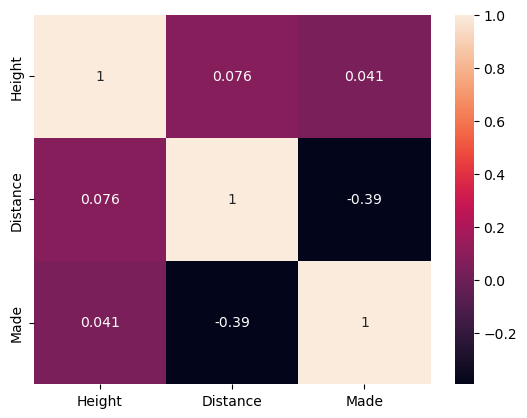

In [2]:
# importing seaborn to view a heatmap of the correlation of the features
import seaborn as sns
sns.heatmap(df.corr(),annot=True)

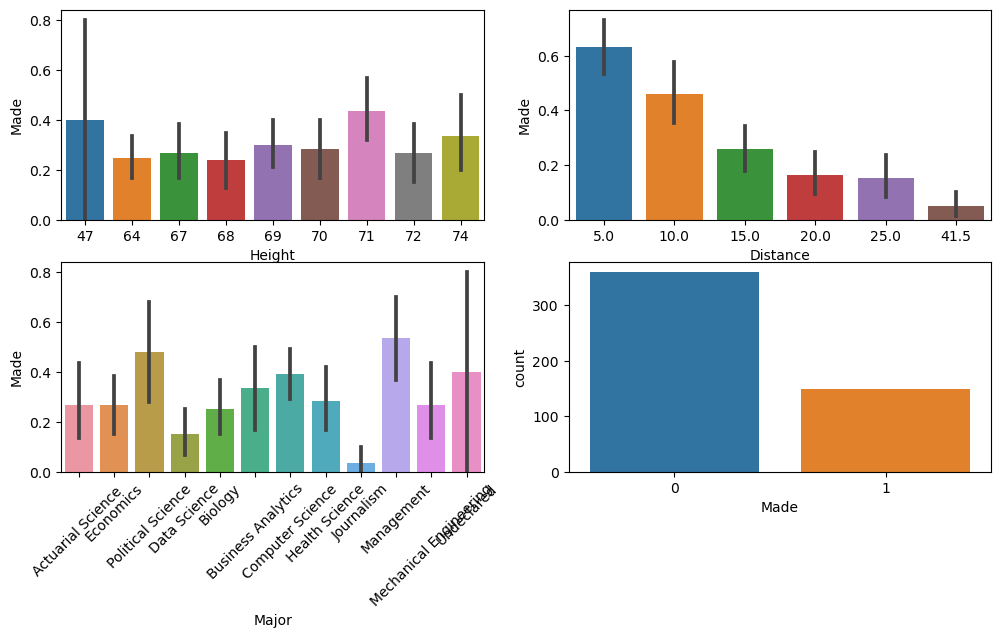

In [3]:
# The following user-defined function is for visulizations of the features in the dataframe
import matplotlib.pyplot as plt
def desc_subplots(df):
    plt_,axs = plt.subplots(2,2,figsize=(12,6))
    sns.barplot(df,x='Height',y='Made',ax=axs[0,0])
    sns.barplot(df,x='Distance',y='Made',ax=axs[0,1])
    sns.barplot(df,x='Major',y='Made',ax=axs[1,0])
    sns.countplot(df,x='Made',ax=axs[1,1])
    axs[1,0].tick_params(axis='x',rotation=45)
    plt.show()


desc_subplots(df)

In [4]:
# using 'Made' as the dependent variable,train/test, testing data consists of 20% of the training data, factorized 'Made'
# and 'Major' because they are strings and need to be converted into numerical values. Then, model selection
# and predictions

df['Major'] = pd.factorize(df['Major'])[0]
df['Name'] = pd.factorize(df['Name'])[0]


X = df.drop('Made',axis=1)
y = df[['Made']]


from sklearn.model_selection import train_test_split


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=0)


from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X_train,y_train)
clf_pred = clf.predict(X_test)
clf_pred_prob = clf.predict_proba(X_test)[::,1]


from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

rfc = RandomForestClassifier().fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
rfc_pred_prob = rfc.predict_proba(X_test)[::,1]



gbc = GradientBoostingClassifier().fit(X_train,y_train)
gbc_pred = gbc.predict(X_test)
gbc_pred_prob = gbc.predict_proba(X_test)[::,1]

from sklearn.naive_bayes import GaussianNB

nbc = GaussianNB().fit(X_train,y_train)
nbc_pred = nbc.predict(X_test)
nbc_pred_prob = nbc.predict_proba(X_test)[::,1]

In [5]:
# Now, scoring the accuracy and roc_auc score of each model
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score


def evaluate_model(model_name,y_true,y_pred,y_pred_prob):
    acc = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred_prob)
    print(f'{model_name} - Accuracy: {acc * 100:.2f}%, ROC-AUC: {roc * 100:.2f}%')

evaluate_model('Logistic Regression', y_test,clf_pred,clf_pred_prob)
evaluate_model('Random Forest', y_test,rfc_pred,rfc_pred_prob)
evaluate_model('Naive Bayes', y_test,nbc_pred,nbc_pred_prob)
evaluate_model('Gradient Boosting',y_test,gbc_pred,gbc_pred_prob)

Logistic Regression - Accuracy: 81.37%, ROC-AUC: 81.44%
Random Forest - Accuracy: 81.37%, ROC-AUC: 81.20%
Naive Bayes - Accuracy: 81.37%, ROC-AUC: 81.44%
Gradient Boosting - Accuracy: 77.45%, ROC-AUC: 81.25%


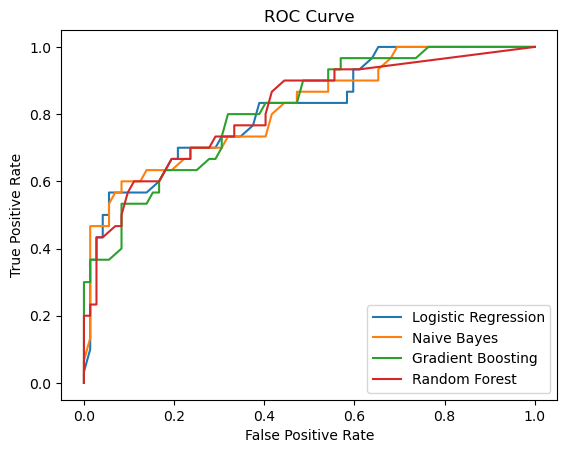

In [6]:
# ROC_Curve plots comparing all of the models in one frame
def roc_curve_plot(y_test, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr,tpr,label=model_name)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

roc_curve_plot(y_test,clf_pred_prob,'Logistic Regression')
roc_curve_plot(y_test,nbc_pred_prob,'Naive Bayes')
roc_curve_plot(y_test,gbc_pred_prob,'Gradient Boosting')
roc_curve_plot(y_test,rfc_pred_prob,'Random Forest')
plt.legend()
plt.show()

In [7]:
# 10-fold Cross-validation (excluding Naive Bayes classifier) through polynomial features to see the highest possible
# roc_that can be obtained before over-fitting occurs. This is just for fun.
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import cross_val_score


def evaluate_cv_model(model,X,y,cv=10):
    poly = PolynomialFeatures(2)
    X_poly = poly.fit_transform(X)

    cv_scores = cross_val_score(model,X_poly,y,cv=cv,scoring='roc_auc')
    max_roc_auc = cv_scores.max()


    print(f'{model.__class__.__name__} Cross-Validated ROC-AUC Scores:')
    print(cv_scores)
    print(f'Max ROC-AUC: {max_roc_auc * 100:.2f}%')

    return max_roc_auc




clf_lr = LogisticRegression()
clf_rf = RandomForestClassifier()
clf_gb = GradientBoostingClassifier()
roc_auc_lr = evaluate_cv_model(clf_lr,X,y)
roc_auc_rf = evaluate_cv_model(clf_rf,X,y)
roc_auc_gb = evaluate_cv_model(clf_gb,X,y)

LogisticRegression Cross-Validated ROC-AUC Scores:
[0.74074074 0.57314815 0.84814815 0.80092593 0.75277778 0.76481481
 0.86018519 0.75925926 0.79074074 0.91312741]
Max ROC-AUC: 91.31%
RandomForestClassifier Cross-Validated ROC-AUC Scores:
[0.52222222 0.33611111 0.62777778 0.38240741 0.25648148 0.40555556
 0.51944444 0.41481481 0.61296296 0.7046332 ]
Max ROC-AUC: 70.46%
GradientBoostingClassifier Cross-Validated ROC-AUC Scores:
[0.46296296 0.3212963  0.66666667 0.68981481 0.40277778 0.27962963
 0.5287037  0.5037037  0.7        0.80694981]
Max ROC-AUC: 80.69%
